У цьому ноутбуці ми розберемо явище мультиколінеарності, та способи протидії мультиколінеарності.

Мультиколінеарність можна побачити по кореляційній матриці даних (багато значень >0.9 )

Розберемо типові способи протидії мультиколінеарності:

1) відкидання зайвих ознак

2) регуляризація (регресії Ridge, Lasso)

3) перехід у новий простір ознак (метод головних компонент - PCA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

In [2]:
data = pd.read_csv("train.csv", index_col = 'id')
data.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [3]:
categorical = ['Sex']
target = 'Age'
numerical = data.columns.difference(categorical+[target]).tolist()

numerical

['Diameter',
 'Height',
 'Length',
 'Shell Weight',
 'Shucked Weight',
 'Viscera Weight',
 'Weight']

Outlier removal

In [4]:
for col in numerical:
    mean, std = data[col].mean(), data[col].std()
    data = data[(data[col]>=mean-3*std) & (data[col]<=mean+3*std) ]

<Axes: >

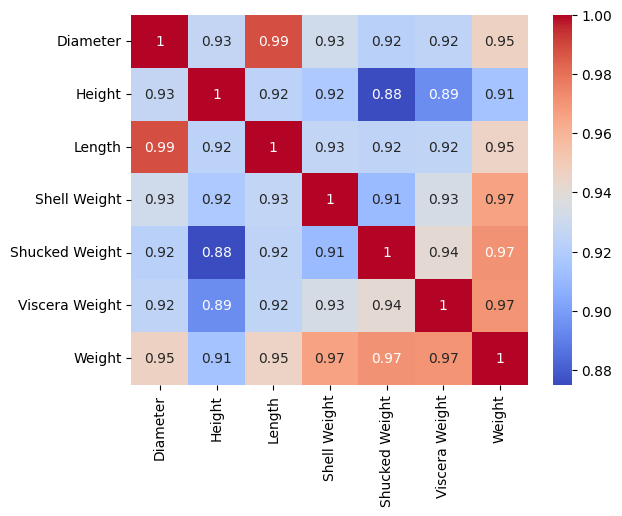

In [5]:
sns.heatmap(data[numerical].corr(), cmap = 'coolwarm', annot = True)

По матриці кореляцій можна бачити, що в даних висока мультиколінеарність (практично всі змінні корелюють одна із одною із $ r_{ij} >=0.9 $

In [6]:
data[numerical].corrwith(data[target]).sort_values(ascending=False)

Shell Weight      0.656645
Height            0.631624
Diameter          0.604829
Length            0.596164
Weight            0.592570
Viscera Weight    0.566500
Shucked Weight    0.491941
dtype: float64

### Чи впливає стандартизація на кореляцію в даних?

$$ X_{stded} = \cfrac{X - \mu}{\sigma} $$

In [7]:
## standartization
data_stded = data.copy()

for col in numerical:
    mean, std = data_stded[col].mean(), data_stded[col].std()
    data_stded[col] = (data_stded[col] - mean)/(std)

In [8]:
#спосіб зробити те саме, але через sklearn
"""
from sklearn.preprocessing import StandardScaler
std_scaler = StandartScaler()
data_stded_arr = std_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками
data_stded = pd.DataFrame(data_stded, columns = numerical) #повертаємо назви колонок

#категорійні колонки не змінюємо
for cat_col in categorical:
    data_stded[cat_col] = data[cat_col]
"""

'\nfrom sklearn.preprocessing import StandardScaler\nstd_scaler = StandartScaler()\ndata_stded_arr = std_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками\ndata_stded = pd.DataFrame(data_stded, columns = numerical) #повертаємо назви колонок\n\n#категорійні колонки не змінюємо\nfor cat_col in categorical:\n    data_stded[cat_col] = data[cat_col]\n'

### Дивимось, чи змінилася матриця кореляції при стандартизації даних

In [9]:
(data[numerical].corr() - data_stded[numerical].corr()).round(5)

,Diameter,Height,Length,Shell Weight,Shucked Weight,Viscera Weight,Weight
Diameter,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0
Height,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
Length,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
Shell Weight,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0
Shucked Weight,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
Viscera Weight,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weight,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0


### Чи змінюється кореляція даних при mix-max нормуванні?

$$ X_{normed} = \cfrac{X - X_{min}}{X_{max}-X_{min}} $$

In [10]:
## normalization
data_normed = data.copy()

for col in numerical:
    min_, max_ = data_normed[col].min(), data_normed[col].max()
    data_normed[col] = (data_normed[col] - min_)/(max_ - min_)

In [11]:
#спосіб зробити те саме, але через sklearn
"""
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
data_normed_arr = minmax_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками
data_normed = pd.DataFrame(data_normed, columns = numerical) #повертаємо назви колонок

#категорійні колонки не змінюємо
for cat_col in categorical:
    data_normed[cat_col] = data[cat_col]
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\nminmax_scaler = MinMaxScaler()\ndata_normed_arr = minmax_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками\ndata_normed = pd.DataFrame(data_normed, columns = numerical) #повертаємо назви колонок\n\n#категорійні колонки не змінюємо\nfor cat_col in categorical:\n    data_normed[cat_col] = data[cat_col]\n'

In [12]:
(data[numerical].corr() - data_normed[numerical].corr()).round(5)

,Diameter,Height,Length,Shell Weight,Shucked Weight,Viscera Weight,Weight
Diameter,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
Height,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0
Length,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0
Shell Weight,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
Shucked Weight,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0
Viscera Weight,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weight,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0


Надалі в цьому ноутбуці, будемо вважати що ми вже привели дані до одної шкали і будемо в основному користуватись data_stded.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


X_train, X_test, y_train, y_test = train_test_split(data_stded[numerical], data_stded[target], test_size=0.2)

In [14]:
models_list = dict()
y_test_pred_list = dict()

Побудуємо типову модель лінійної регресії на всіх змінних, щоб далі нам було від чого відштовхуватись:

In [15]:
from sklearn.linear_model import LinearRegression

key = "lr_basic"

lr = LinearRegression(fit_intercept = True)
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)

models_list[key] = lr; y_test_pred_list[key] = y_test_pred

lr.intercept_, lr.coef_

(9.992966191653778,
 array([ 0.52118196,  0.7941479 ,  0.17196316,  1.91854829, -3.49223166,
        -0.54838514,  2.53554564]))

In [16]:
r2_score(y_test, y_test_pred)

0.5313304075984808

### 1) Відкидання непотрібних змінних

Якщо знаходимо деяку пару змінних, яка корелює більше ніж 0.95, з двох залишаємо тільки одну

In [17]:
data[numerical].corr()

,Diameter,Height,Length,Shell Weight,Shucked Weight,Viscera Weight,Weight
Diameter,1.000000,0.926579,0.988614,0.931288,0.922352,0.924603,0.946684
Height,0.926579,1.000000,0.923368,0.917790,0.875035,0.894434,0.914670
Length,0.988614,0.923368,1.000000,0.925975,0.924567,0.924915,0.945543
Shell Weight,0.931288,0.917790,0.925975,1.000000,0.911109,0.933734,0.966070
Shucked Weight,0.922352,0.875035,0.924567,0.911109,1.000000,0.941362,0.970952
Viscera Weight,0.924603,0.894434,0.924915,0.933734,0.941362,1.000000,0.970414
Weight,0.946684,0.914670,0.945543,0.966070,0.970952,0.970414,1.000000


In [18]:
relevant_cols = ["Diameter", 'Height', "Shell Weight", "Shucked Weight", 'Viscera Weight']
data[relevant_cols].corr()

,Diameter,Height,Shell Weight,Shucked Weight,Viscera Weight
Diameter,1.000000,0.926579,0.931288,0.922352,0.924603
Height,0.926579,1.000000,0.917790,0.875035,0.894434
Shell Weight,0.931288,0.917790,1.000000,0.911109,0.933734
Shucked Weight,0.922352,0.875035,0.911109,1.000000,0.941362
Viscera Weight,0.924603,0.894434,0.933734,0.941362,1.000000


In [19]:
from sklearn.linear_model import LinearRegression

key = "lr_cutted"

lr = LinearRegression(fit_intercept = True)
lr.fit(X_train[relevant_cols], y_train)

y_test_pred = lr.predict(X_test[relevant_cols])

models_list[key] = lr; y_test_pred_list[key] = y_test_pred

lr.intercept_, lr.coef_

(9.992557426005307,
 array([ 0.75300126,  0.82476789,  2.80099828, -2.49689066,  0.06780303]))

In [20]:
r2_score(y_test, y_test_pred)

0.5212884469696358

Видалення змінних може допомогти, може - і ні;

В даному випадку бачимо, що видалення змінних по взаємній колінеарності сильно не змінює ситуацію

### 2. Регуляризація

Альтернативами звичайній лінійній регресії є регуляризовані моделі Ridge і Lasso

LinearRegression: $ || X \beta - y ||^2 \rightarrow min_{\beta} $

Ridge: $ || X \beta - y ||^2 + \lambda \sum_{i=1}^n \beta_i^2 \rightarrow min_{\beta} $

Lasso: $ || X \beta - y ||^2 + \lambda \sum_{i=1}^n | \beta_i | \rightarrow min_{\beta} $

Змінюючи $ \lambda $ , можемо змінювати силу регуляризації

In [21]:
from sklearn.linear_model import Ridge, Lasso

for alpha in [1e-5, 1e-3, 1e0, 1e5, 1e10]:

    key = f"ridge_{alpha}"

    lr = Ridge(alpha = alpha, fit_intercept = True)
    lr.fit(X_train, y_train)

    y_test_pred = lr.predict(X_test)

    models_list[key] = lr; y_test_pred_list[key] = y_test_pred

    print(f"alpha = {alpha}, r2_score = {round(r2_score(y_test, y_test_pred), 5)}, coef = {lr.coef_.round(5)}")

alpha = 1e-05, r2_score = 0.53133, coef = [ 0.52118  0.79415  0.17196  1.91855 -3.49223 -0.54839  2.53555]
alpha = 0.001, r2_score = 0.53133, coef = [ 0.52118  0.79415  0.17196  1.91855 -3.49223 -0.54838  2.53554]
alpha = 1.0, r2_score = 0.53133, coef = [ 0.52109  0.79424  0.17201  1.91966 -3.4899  -0.5474   2.53117]
alpha = 100000.0, r2_score = 0.36918, coef = [0.23815 0.30383 0.22413 0.33639 0.05984 0.18213 0.21268]
alpha = 10000000000.0, r2_score = 3e-05, coef = [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]


In [22]:
from sklearn.linear_model import Ridge, Lasso

for alpha in [1e-4, 1e-2, 1e0, 1e2]:

    key = f"lasso_{alpha}"

    lr = Lasso(alpha = alpha, fit_intercept = True)
    lr.fit(X_train, y_train)

    y_test_pred = lr.predict(X_test)

    models_list[key] = lr; y_test_pred_list[key] = y_test_pred

    print(f"alpha = {alpha}, r2_score = {round(r2_score(y_test, y_test_pred), 5)}, coef = {lr.coef_.round(5)}")

alpha = 0.0001, r2_score = 0.53132, coef = [ 0.52129  0.79416  0.171    1.92076 -3.48759 -0.54467  2.52599]
alpha = 0.01, r2_score = 0.52878, coef = [ 0.52425  0.79421  0.08278  2.1393  -3.0297  -0.17837  1.5856 ]
alpha = 1.0, r2_score = 0.32569, coef = [0.      0.03799 0.      1.01865 0.      0.      0.     ]
alpha = 100.0, r2_score = -0.0, coef = [0. 0. 0. 0. 0. 0. 0.]
